# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [21]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # showing digits
from PIL import Image           # loading from file

from abc import abstractmethod, ABC
from typing import List
import numpy as np

#np.random.seed(1)

XOR_x = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
XOR_y = np.array([[[0]], [[1]], [[1]], [[0]]])

In [24]:
mnist = fetch_openml('mnist_784',version=1,as_frame=False)

### Parametry

In [78]:

# turns 0-9 numbers into 0,1 array
def NumbersToVectors(classes: np.ndarray):
    def AsVector(n, k):
        return np.array([[1 if x == n else 0 for x in range(k)]])

    biggest = int(max(classes))
    out = []
    for num in classes:
        out.append(AsVector(num, biggest+1))  # 0-9, not 1-9
    return out

# parameters
# epsilon is used to stop training when desired accuracy is hit
# flattenedImages = np.array([[np.ndarray.flatten(img)]
#                           for img in mnist.data])
flattenedImages = np.array([ np.array([x]) for x in mnist.data])
targetVectors = NumbersToVectors(list(map(int,mnist.target)))
x_train, x_test, y_train, y_test = train_test_split(flattenedImages, targetVectors, test_size=0.8, random_state=123)
learningRate = 0.01
epochs = 4

epsilonXOR = 0.000001  # only for XOR
architectureXOR = [3, 3]
# MNIST
architectureMNIST = [50, 20, 10]

In [79]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        # tanh is symmetrical around 0, so let's roll random values
        # around 0 too
        # [-1,1), mxn matrix
        self.weights = (np.random.rand(input_size, output_size)-0.5)/2
        # [-1,1) x input_size array
        self.bias = (np.random.rand(1, output_size)-0.5)/2

        self.inputs = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        '''
        Multiplies incoming values by weights and adds bias.
        X⋅weights+bias
         ^ dot product
        '''
        # remember this for backprop later
        self.inputs = np.array(x)  # @TODO: Copy needed?

        return x@self.weights+self.bias

    def backward(self, output_error_derivative: np.ndarray, learningRate) -> np.ndarray:
        '''
        From layer point of view, I am interested in
        how weights and biases influence error, and we want
        to minimise that. so we need dy/dw and dy/db, then follow the gradient.

        but other layers want the derivative too, so tell them how their
        data that is being fed here (input) changes the error.
        Therefore return dy/dx.
        '''
        wGradient = self.inputs.T@output_error_derivative

        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # this must be calculated before updating weights...
        # siedziałem do 3 w nocy żeby ten błąd znaleźć :)
        result = output_error_derivative@self.weights.T

        # subtract from weights, but not fully
        self.weights -= wGradient*learningRate

        # same for biases
        self.bias -= learningRate * output_error_derivative

        # return dy/dx

        return result


class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.inputs = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        return np.tanh(x)

    def backward(self, output_error_derivative, l) -> np.ndarray:
        # no weights to update here, pass back the derivative
        # from chain rule (?):
        # f(x) - our function (tanh)
        # y - error
        # x - our layer input
        # dy/dx = dy/df * df/dx
        return (1-np.tanh(self.inputs)**2) * output_error_derivative


class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """Loss function for a particular x """
        return self.loss_function(x, y)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)


class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss = None

    def compile(self, loss: Loss) -> None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        current_input = x
        for layer in self.layers:
            current_input = layer.forward(current_input)
        return current_input

    def fit(self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            epochs: int,
            epsilon: float,
            verbose: int = 0) -> None:
        """Fit the network to the training data"""

        for e in range(epochs):
            if verbose:
                print("epoch", e+1)
            errorsum = 0
            for sample_x, target in zip(x_train, y_train):
                # forward pass
                result = self(sample_x)

                errorsum += self.loss.loss_function(result, target)

                derivative = self.loss.loss_derivative(result, target)
                for layer in self.layers[::-1]:
                    derivative = layer.backward(derivative, self.learning_rate)
            # sometimes it excells in some samples and is atricious at others,
            # therefore sum the errors of all samples and print this
            if verbose:
                print("epoch error sum:", errorsum/len(x_train))
            #if errorsum/len(x_train) < epsilon:
            #    return

def CreateNetwork(inputSize, networkShape, outputSize, rate):
    networkShape.append(outputSize)  # easier looping
    inputLayer = FullyConnected(inputSize, networkShape[0])
    inputTanh = Tanh()
    hiddenLayers = []
    for i in range(len(networkShape)-1):
        hiddenLayers.append(FullyConnected(networkShape[i], networkShape[i+1]))
        hiddenLayers.append(Tanh())

    # remove last tanh? Or no difference?
    allLayers = [inputLayer, inputTanh]+hiddenLayers

    return Network(allLayers, rate)


# Mean Squared Error
def msefunc(result, target):
    return np.mean(np.power(result-target, 2))


def msederivative(result, target):
    return 2*(result-target)/result.size



# expects two training arrays of samples vs outputs
def FittedNetwork(inputs, outputs, networkShape, learningRate, epochCount, epsilon):

    inputSize = inputs[0].size
    outputSize = outputs[0].size

    # driver code
    net = CreateNetwork(inputSize, networkShape,
                        outputSize, learningRate)

    MSE = Loss(msefunc, msederivative)
    net.compile(MSE)

    net.fit(x_train, y_train, epochCount, epsilon, verbose=False)

    return net

In [80]:

MNISTnetwork = FittedNetwork(x_train,  y_train,
                            architectureMNIST, learningRate, epochs, 0)

Train efficiency: 75.93%


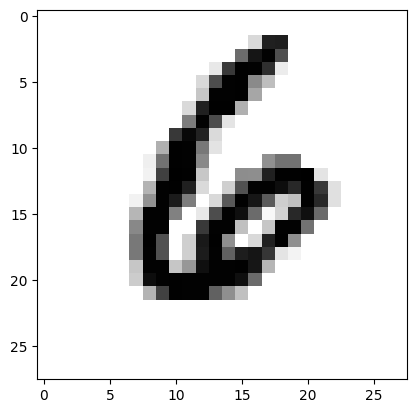

target:  6
result:  [[ 0.06  0.05 -0.01 -0.1   0.16  0.1   0.64 -0.01  0.03 -0.02]]
Guess: 6


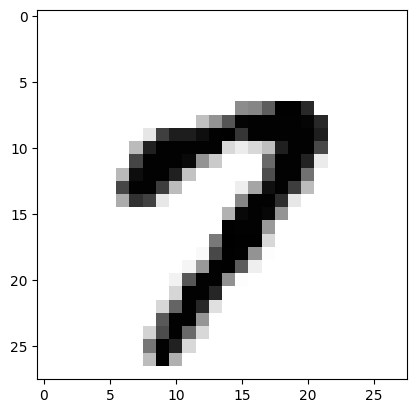

target:  7
result:  [[ 0.06 -0.01  0.01 -0.09  0.02 -0.1  -0.02  0.74  0.05  0.19]]
Guess: 7


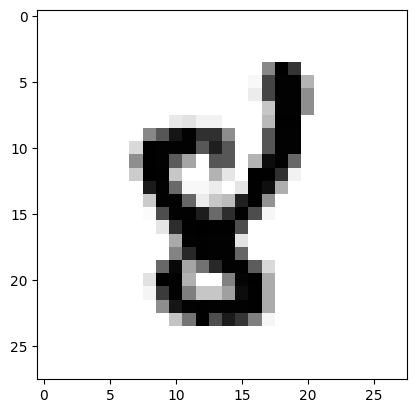

target:  8
result:  [[ 0.23  0.08 -0.01  0.01  0.41 -0.11 -0.03  0.02  0.16  0.23]]
Guess: 4


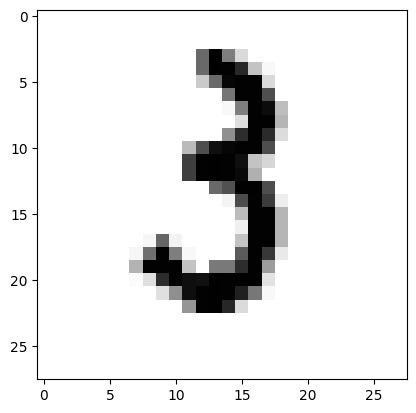

target:  3
result:  [[-0.09  0.48 -0.04  0.62 -0.16  0.07  0.12 -0.    0.03 -0.06]]
Guess: 3


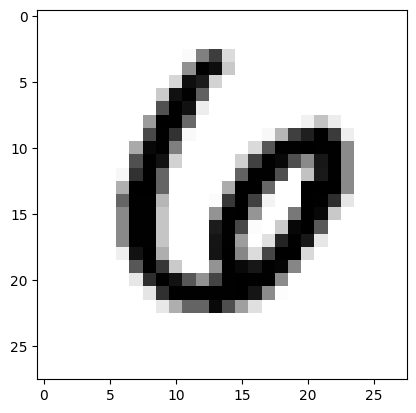

target:  6
result:  [[ 0.16  0.05  0.13 -0.09  0.17  0.05  0.25 -0.01  0.22  0.05]]
Guess: 6


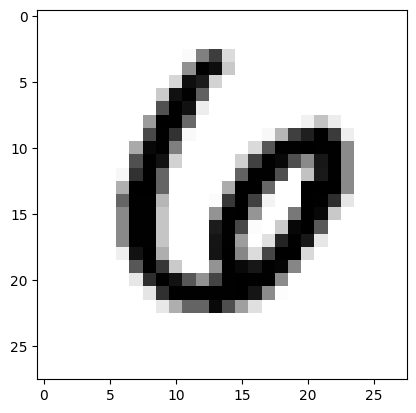

target:  6
result:  [[ 0.16  0.05  0.13 -0.09  0.17  0.05  0.25 -0.01  0.22  0.05]]
Guess: 6


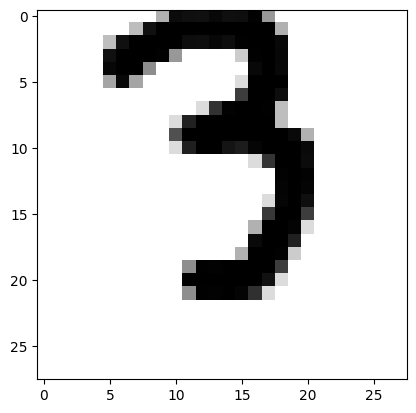

result:  [[ 0.06 -0.08 -0.08  0.33 -0.03 -0.02  0.11  0.63 -0.05  0.13]]
Guess: 7


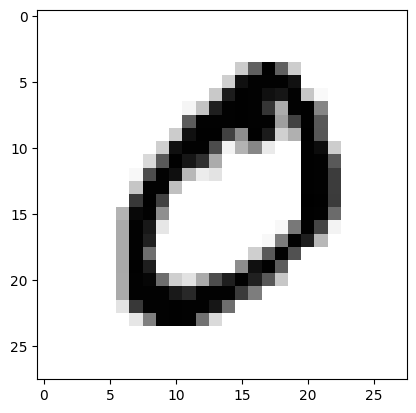

target:  0
result:  [[ 0.78  0.03 -0.03 -0.01  0.01  0.1  -0.01  0.04 -0.13  0.  ]]
Guess: 0


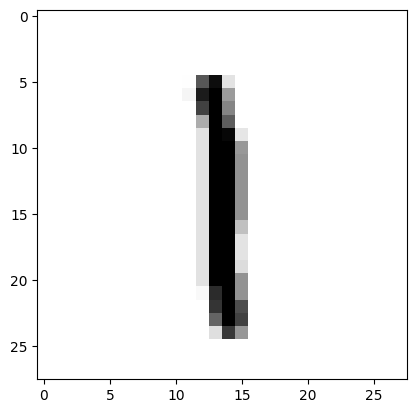

target:  1
result:  [[ 0.07  0.81  0.05 -0.09 -0.06  0.05  0.03 -0.07  0.02  0.05]]
Guess: 1


ValueError: invalid literal for int() with base 10: ''

In [81]:
def doXOR(epsilon, architecture):
    network = FittedNetwork(XOR_x, XOR_y, architecture,
                            learningRate, epochs, epsilon)

    result1 = network([0, 0])
    result2 = network([0, 1])
    result3 = network([1, 0])
    result4 = network([1, 1])

    print("results:", result1, result2, result3, result4)


def doMNIST():
    # 5th index image is labeled as 5
    # but it looks like 9, can't blame the network
    # plt.imshow(mnist.images[5], cmap='binary')
    # plt.show()
    
    counter = 0
    for x, y in zip(x_test, y_test):
        if np.argmax(MNISTnetwork(x)) == np.argmax(y):
            counter += 1
    print(f"Train efficiency: {100*counter/len(y_test):.2f}%")

    while True:
        i = input(f"\nType index (max {len(flattenedImages)-1}) or 'file':")
        if i == "file":
            userImage = np.asarray(Image.open(
                'image.bmp').convert('L'), dtype='float64')/16
            plt.imshow(userImage, cmap='binary')
            plt.show()
            flattened = np.array([np.ndarray.flatten(userImage)])
            result = MNISTnetwork(flattened)
        else:
            i = int(i)
            reshaped = np.reshape(mnist.data[i],(28,28))
            plt.imshow(reshaped, cmap='binary')
            plt.show()
            img = Image.fromarray(reshaped*16).convert('L')
            img.save('image.bmp')
            print("target: ", mnist.target[i])
            result = MNISTnetwork(mnist.data[i])
        print("result: ", result.round(2))
        print(f"Guess: {np.argmax(result)}")


doMNIST()
#doXOR(epsilonXOR, architectureXOR)

# Wnioski

## Eksperyment XOR

Potwierdzenie działania sieci neuronowej. Potrafi rozwiązać problem nawet z jedną warstwą ukrytą o rozmiarze 2, choć wymaga to średnio 500 epok do znalezienia idealnego rozwiązania.

Ważny tutaj jest rozmiar warstw ukrytych, a nie ilość. Pozostając przy jednej warstwie ukrytej, a zwiększając ilość neuronów, sieć potrzebuje coraz mniej epok:

rozmiar a ilość potrzebnych epok (w przybliżeniu)
2x1: 800
3x1: 500
4x1: 400
10x1: 200

Paradoksalnie, poszerzanie sieci bez zwiększania rozmiaru warstw powoduje wpadanie w nieprawidłowe minimum lokalne, wtedy sieć zwraca około 0.5 dla każdej próby i stoi w miejscu z wagami.

Próby z głębokimi sieciami typu 10x10 również dają się trenować, ale potrafi to zająć bardzo dużo epok (kilka tysięcy) a nie daje lepszego efektu w tym problemie..

## MINST

Funkcja błedu to średnia różnic kwadratowych wyniku sieci od prawidłowej odpowiedzi.
Do policzenia błędu dla danej epoki sumuję błedy dla każdego przypadku treningowego, wtedy wiadomo jak to wychodzi średnio dla wszystkich danych. Również po skończeniu treningu sprawdzam na ile próbek z całego zbioru sieć odpowiada dobrze. 

Wybranie poprawnej architektury sieci jest trudne, oto kilka prób i trafność sieci po 100 epokach:
(seed ustawiany poprzez np.random.seed(n), wpływa na to jak losowane są wagi w sieci)

Architektura            Seed 0      Seed 1      Seed 2
* [64, 32, 16, 8, 4]    50.31%      50.42%      48.41%
* [100, 50, 20]         96.33%      99.39%      99.72%
* [50, 50, 50]          97.44%      95.99%      98.11%
* [200, 100, 50, 20]    >99.9%      >99.9%      >99.9%
* [200, 100]            >99.9%      98.23%      99.61%
* [50, 20, 10] (*)      99.00%      99.22%      95.83%    
* [50, 30, 20, 10]      93.16%      95.43%      93.11%
* [30]                  93.49%      95.27%

Do bardziej manualnych testów wybrałem taką (*) architekturę, bo ma dobre wyniki i jest dosyć szybka. Można wyrywkowo pytać sieć o jakieś cyfry ze zbioru, można też załadować ręcznie narysowaną cyfre (plik `image.bmp`) i wytrenowana sieć spróbuje ją odczytać. Wyniki nie są takie optymistyczne, prawdopodobnie zachodzi przeuczenie, ale i tak większość prób działa.